In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
# Step 2: Prepare the Data ---------------------------------------------------------------------
# ------------------------
# Load main data
# ------------------------
df = pd.read_csv("data.csv")

time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
import bisect

def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t) for t in time])

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts.reshape(-1, 1)])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the 3-row / 3 ms rule
# ------------------------
dt_target = 0.003      # 3 ms
dt_tol = 0.0005        # ±0.5 ms

inputs = []
outputs = []

N = len(df)

for i in range(N - 3):
    dt = time[i+3] - time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(data_aug[i])   # augmented input with event_count
        outputs.append(data[i+3])    # output is ONLY the data (no event count)

X = torch.tensor(inputs, dtype=torch.float32)
Y = torch.tensor(outputs, dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   # features + 1
print("Output shape:", Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# -----------------------------------------------------------------------------------------------


Pairs created: 374997
Input shape : torch.Size([374997, 101])
Output shape: torch.Size([374997, 100])


In [8]:
# Step 3: Initialize the Model, Loss Function, and Optimizer
batch_size = 64
input_size = X.shape[1] # set input_size equal to the width of tensor X
output_size = Y.shape[1] # set output_size equal to the width of tensor Y
hidden_size = 128
model = NeuralNetwork(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size)

In [14]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?``

In [10]:
# Step 4: Train the Model
model.train()
num_epochs = 50
for epoch in range(num_epochs):
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 2.2571
Epoch [2/50], Loss: 1.8340
Epoch [3/50], Loss: 1.6405
Epoch [4/50], Loss: 2.1674
Epoch [5/50], Loss: 1.2386
Epoch [6/50], Loss: 3.8401
Epoch [7/50], Loss: 1.2610
Epoch [8/50], Loss: 1.3382
Epoch [9/50], Loss: 1.6655
Epoch [10/50], Loss: 1.6171
Epoch [11/50], Loss: 1.3252
Epoch [12/50], Loss: 2.2895
Epoch [13/50], Loss: 1.4013
Epoch [14/50], Loss: 1.1362
Epoch [15/50], Loss: 1.2903
Epoch [16/50], Loss: 0.9946
Epoch [17/50], Loss: 1.0843
Epoch [18/50], Loss: 1.3467
Epoch [19/50], Loss: 1.3243
Epoch [20/50], Loss: 1.1057
Epoch [21/50], Loss: 2.9291
Epoch [22/50], Loss: 1.0468
Epoch [23/50], Loss: 1.3446
Epoch [24/50], Loss: 1.0963
Epoch [25/50], Loss: 1.4331
Epoch [26/50], Loss: 7.5205
Epoch [27/50], Loss: 1.8454
Epoch [28/50], Loss: 1.1466
Epoch [29/50], Loss: 1.5908
Epoch [30/50], Loss: 1.4190
Epoch [31/50], Loss: 0.9845
Epoch [32/50], Loss: 1.7315
Epoch [33/50], Loss: 2.6152
Epoch [34/50], Loss: 1.3020
Epoch [35/50], Loss: 1.5011
Epoch [36/50], Loss: 0.9133
E

Test Loss: 1.7921


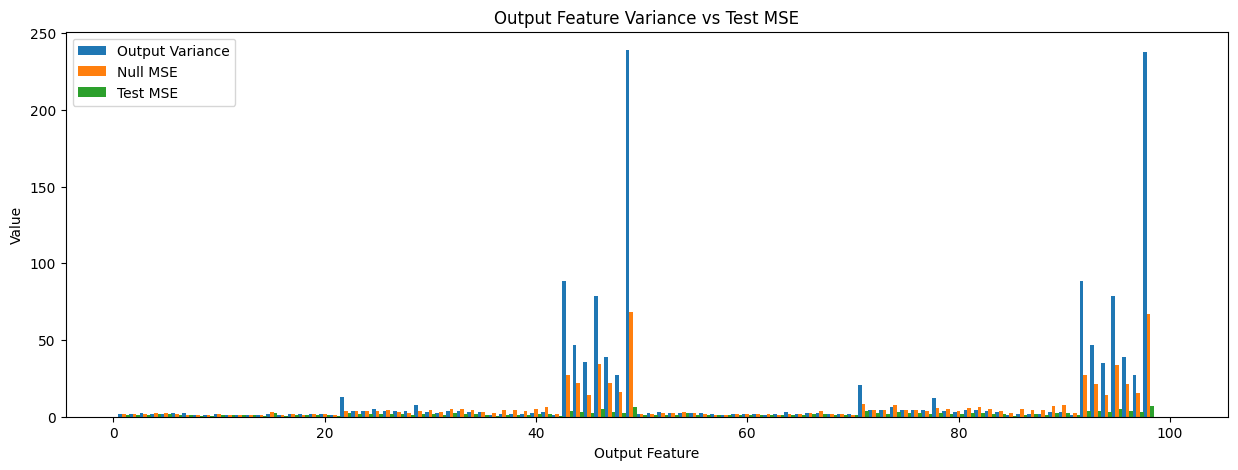

In [25]:
# Step 5: Evaluate the Model on Test Data
model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in test_loader:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        total_loss += loss.item() * X_batch.size(0)  # sum up batch loss

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_test_np = Y_test.numpy()
with torch.no_grad():
    Y_pred_np = model(X_test).numpy()

Y_all_np = Y.numpy()
with torch.no_grad():
    Y_pred_all_np = model(X).numpy()

Y_null_all_np = X.numpy()[:, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

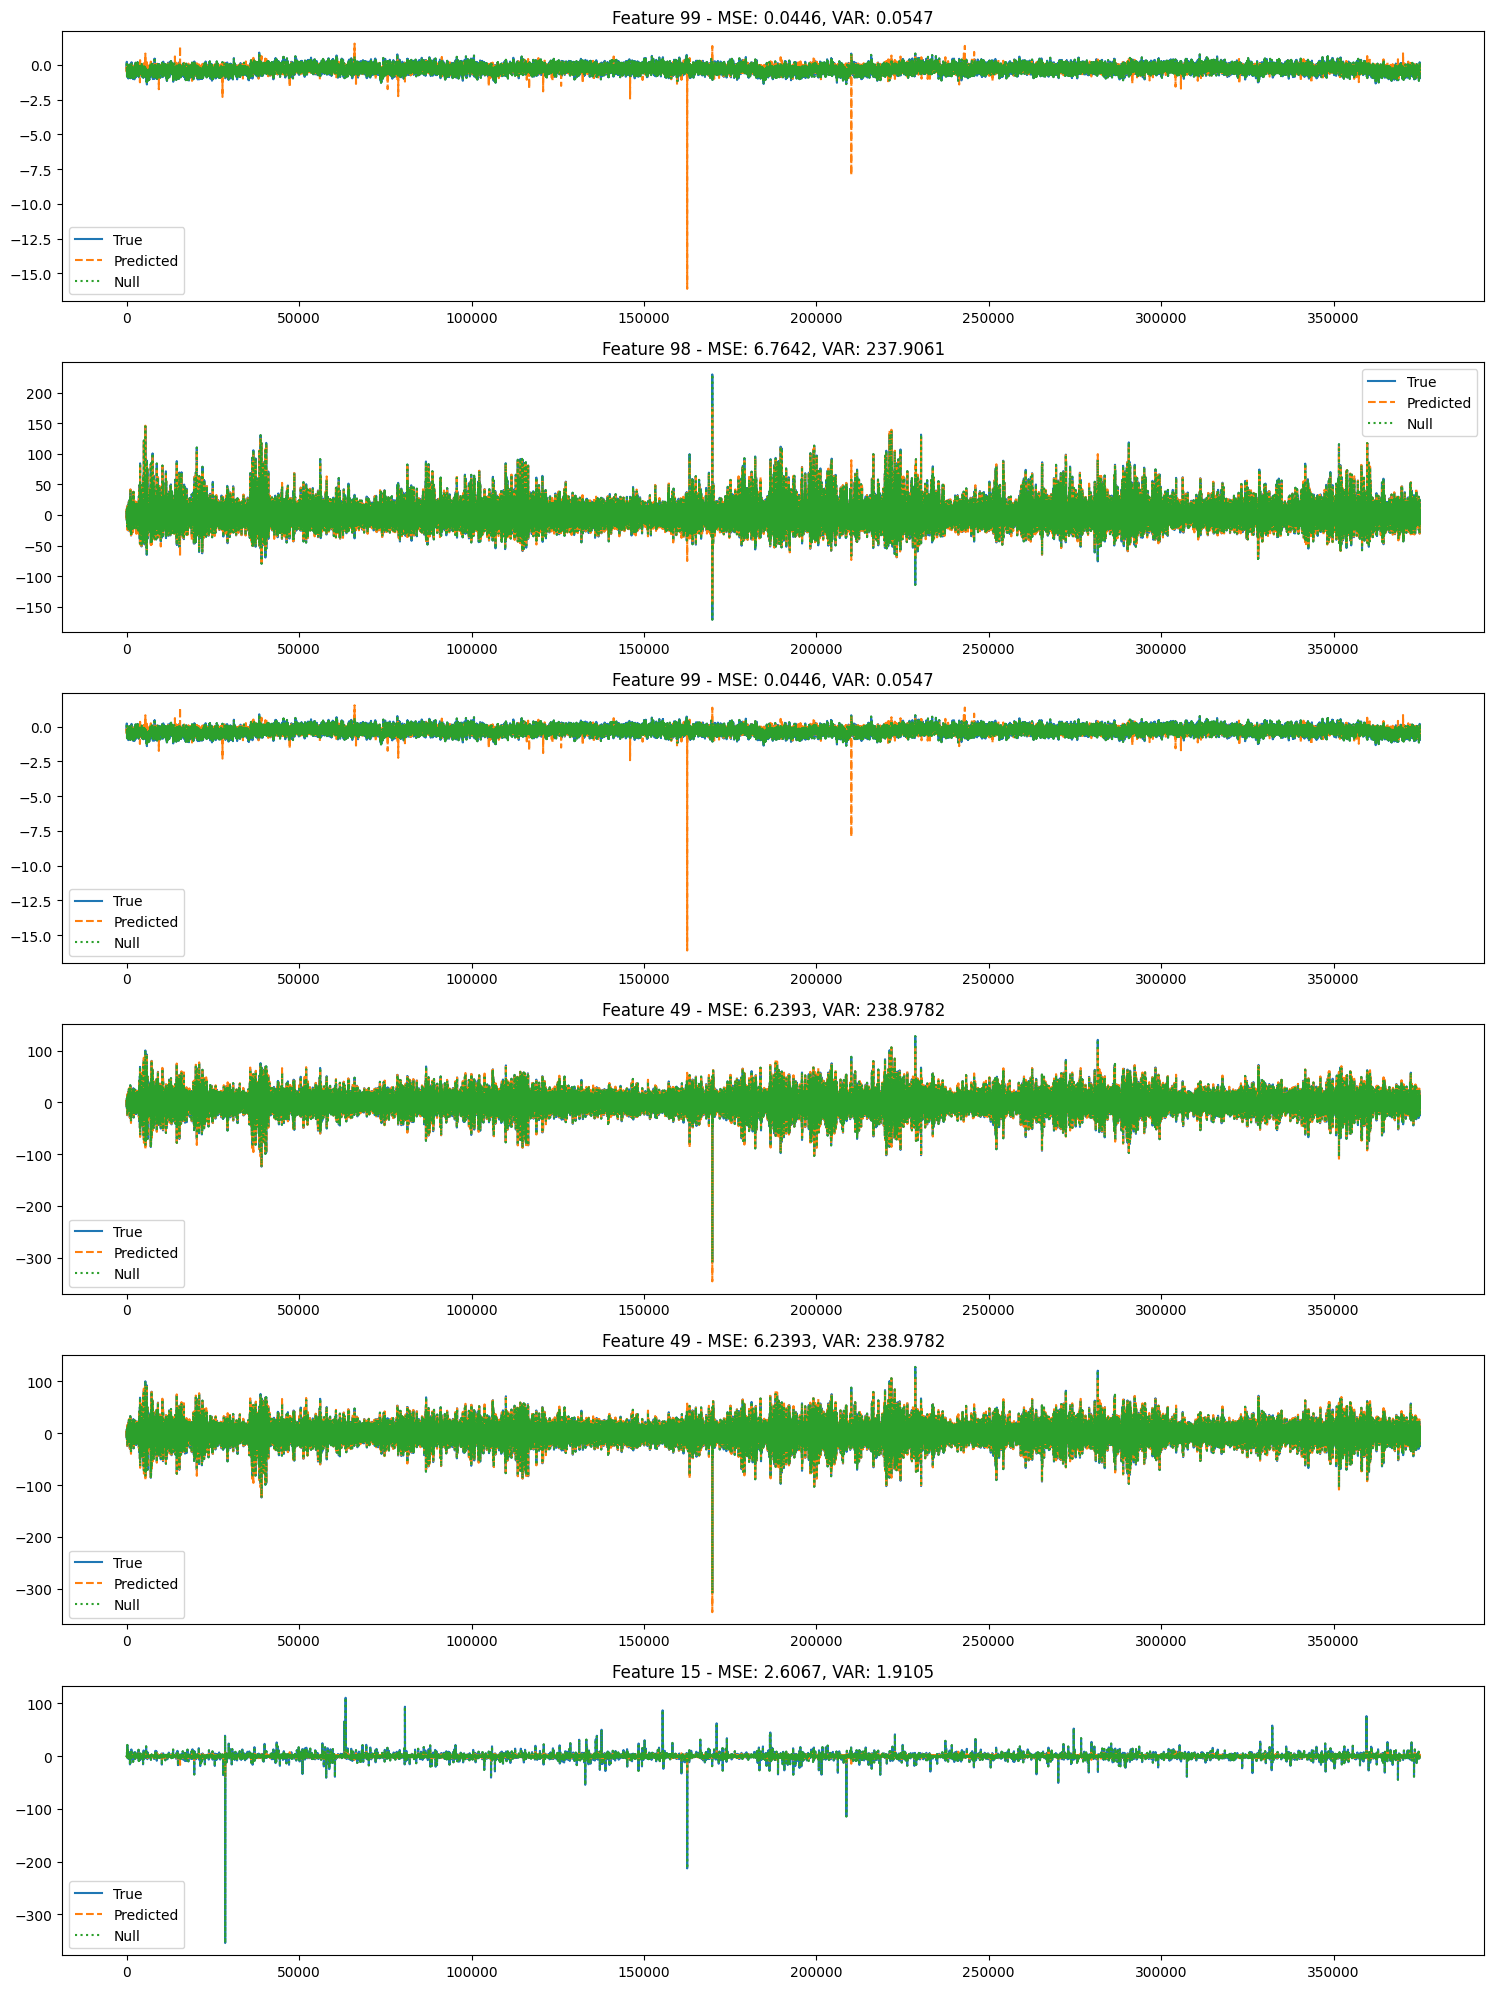

In [26]:
# show several examples 

iMSEmin = np.argmin(MSE_per_feat)
iMSEmax = np.argmax(MSE_per_feat)
iVARmin = np.argmin(var_per_feat)
iVARmax = np.argmax(var_per_feat)
iLRNmin = np.argmin(MSE_per_feat / var_per_feat)
iLRNmax = np.argmax(MSE_per_feat / var_per_feat)
iToPlot = [iMSEmin, iMSEmax, iVARmin, iVARmax, iLRNmin, iLRNmax]

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.title(f'Feature {i+1} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend()
    iPlot += 1
plt.tight_layout()
plt.show()